In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster import vq
import time
import math
from operator import itemgetter
from scipy.spatial import distance
import datetime
import requests
import json
import gensim, logging
from mpl_toolkits.mplot3d import Axes3D
from gensim.models import word2vec
from random import shuffle 

plt.style.use(u'grayscale')
plt.style.available
%matplotlib inline

#### 코드가 조금 난해하지만, 지속적으로 리팩토링할 예정입니다! 

# user-user modeling ( 거리 기반 )

In [29]:
# user의 repository 내 언어 빈도를 파악한 매트릭스 로드
matrix = pd.read_csv("language_mat2.csv", encoding="cp949", index_col=0)   
matrix1 = matrix.drop(["user"], axis=1) # matrix1 = user 이름을 제거한 매트릭스

In [30]:
# 알맞은 군집 개수를 알아보기 위해 탐색
n = int(input("Enter Starting Cluster: "))
n1 = int(input("Enter Ending Cluster: "))
for i in range(n,n1):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10)
    km.fit(matrix1)
    print (i, km.inertia_)

Enter Starting Cluster: 2
Enter Ending Cluster: 17
2 624.82009554
3 523.297959097
4 466.209967973
5 433.685025032
6 399.518934569
7 375.2471596
8 349.044213506
9 317.722344862
10 291.843047287
11 269.170702359
12 255.359503647
13 237.113040341
14 226.074114851
15 218.720894529
16 213.423057043


In [31]:
# 13-14 정도로 군집하면 괜찮을 것 같음
km = KMeans(n_clusters=14, init='k-means++', n_init=10)
km.fit(matrix1)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=14, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [32]:
x = km.fit_predict(matrix1)
matrix["Cluster"]= x # matrix에 cluster 나눈 데이터 추가
matrix.head()

,user,AspectJ,C#,Julia,TypeScript,PostScript,Smalltalk,Scala,Dart,Makefile,...,Thrift,Haskell,D,Modula-2,Ruby,AutoHotkey,ASP,Shell,Perl6,Cluster
0,nainu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,beknazar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,sublime718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,erishforG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,araqne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [35]:
# 유저 거리 구하기(코사인 / 유클리디안)
def cosine_distance(a,b):
    return 1-distance.cosine(a,b)

def euclidean_distance(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [36]:
# 가장 근접한 이웃 찾는 함수
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = matrix1.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    for uid, row in matrix1.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
       
        if interSectionLen < 1 :
            continue
            
        ## similarity functon
        sim = simFunc(interSectionU1,interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    ## top N returned         
    return sorted(nn.items(),key=itemgetter(1))[:-(topN+1):-1]

In [37]:
%%time
# 10번 user와 유사한 user, 코사인 거리를 출력
nearest_neighbor_user(1758, 10, cosine_distance)

Wall time: 16.8 s


[(1583, 1.0),
 (1543, 1.0),
 (1479, 1.0),
 (1387, 1.0),
 (1366, 1.0),
 (1259, 1.0),
 (1150, 1.0),
 (1094, 1.0),
 (1058, 1.0),
 (995, 1.0)]

# item-item modeling( word2vec 활용 )

In [38]:
fork_df = pd.read_csv("last_fork2.csv", encoding="cp949", index_col=0)
user_df = pd.read_csv("main_user4.csv", encoding="cp949", index_col=0)


In [39]:
fork_df.head()

,ID,master,repo_name,Watch,Star,Fork,commit,branch,releases,contributor,...,lan_4,per_4,lan_5,pre_5,lan_6,pre_6,lan_7,pre_7,user,organization
0,dahlia,andreypopp,bw_sphinxtheme,1,6,1,24,1,4,2,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,andreypopp,NaN
1,dahlia,spoqa,geofront,36,198,16,213,3,8,4,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,spoqa
2,dahlia,spoqa,tsukkomi,14,9,3,37,1,4,3,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,spoqa
3,dahlia,spoqa,spoqa-han-sans,32,93,15,37,8,2,7,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,spoqa
4,dahlia,earthreader,libearth,6,23,13,839,15,9,6,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,earthreader


In [40]:
# 중복 master 제거 : 1명이 해당 사람의 자료를 많이 fork 할 경우 가중치를 주지 않음
sentences = [list(fork_df[fork_df['ID']== i]["master"].unique()) for i in fork_df["ID"].unique()] 

# 중복 master 허용한 senetences2. 많이 주는 경우 가중치를 줌
sentences2 = [list(fork_df[fork_df['ID']== i]["master"]) for i in fork_df["ID"].unique()] 

In [41]:
fork_df = fork_df.replace(np.nan,' ', regex=True) # ' ' 제거

In [42]:
# 위 sentences, sentences2 같은 경우 일반 유저와 조직 유저 아이디가 함께 존재했기 때문에
# 일반 유저가 잘 보이지 않음 
# 아래 sentences는 분리한 문장들

In [43]:
user_sentences = [list(fork_df[fork_df['ID']== i]["user"]) for i in fork_df["ID"].unique()]
organization_sentences = [list(fork_df[fork_df['ID']== i]["organization"]) for i in fork_df["ID"].unique()]

In [45]:
# 리스트 안의 [' ' ] 같은 단어 제거
for k in range(1000):
    for i in range(len(user_sentences)):
        try:
            user_sentences[i].remove(' ')
        except:
            pass

    for j in range(len(organization_sentences)):
        try:
            organization_sentences[j].remove(' ')
        except:
            pass

In [46]:
def drawPlot(v, x, y):
    v.plot(kind='scatter', x=x,y=y, figsize=(5,5))
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.02, 0.02)
    for idx, pos in v.iterrows():
        plt.text(pos[x], pos[y], idx )    
        
def draw3DPlot(v, x, y, z):
    fig = plt.figure(figsize=(10,10))
    threedee = fig.gca(projection='3d')
    threedee.scatter(v[x], v[y],v[z] )
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.02, 0.02)
    for idx, pos in v.iterrows():
        threedee.text(pos[x], pos[y],pos[z],  idx )     

In [47]:
# 모델링 : model 1,2는 개인/조직이 합쳐진 상태며 중복 비허용/허용한 차이
# model3,4는 개인/조직을 분리한 상태이며 중복 허용
model1 = word2vec.Word2Vec(sentences, size=100, min_count = 3, window = 10, sg=1) 
model2 = word2vec.Word2Vec(sentences2, size=100, min_count = 3, window = 10, sg=1)
model3 = word2vec.Word2Vec(user_sentences, size=100, min_count = 3, window = 10, sg=1)
model4 = word2vec.Word2Vec(organization_sentences, size=100, min_count = 3, window = 10, sg=1)

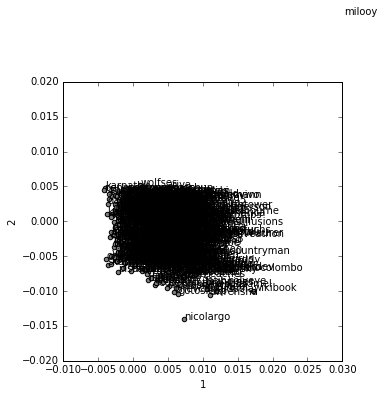

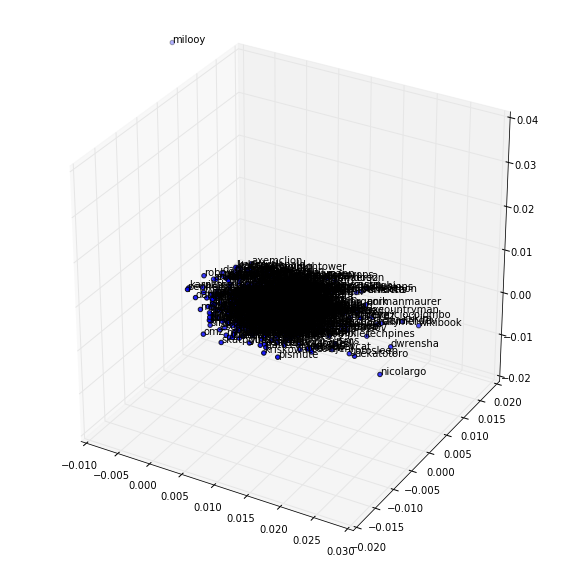

In [48]:
# v = pd.DataFrame(model1.syn0, index=model1.vocab)
# v2 = pd.DataFrame(model2.syn0, index=model2.vocab)
v3 = pd.DataFrame(model3.syn0, index=model3.vocab)
# v4 = pd.DataFrame(model4.syn0, index=model4.vocab)

# drawPlot(v, 1, 2)
# draw3DPlot(v, 0, 1, 2)

# drawPlot(v2, 1, 2)
# draw3DPlot(v2, 0, 1, 2)

drawPlot(v3, 1, 2)
draw3DPlot(v3, 0, 1, 2)

# drawPlot(v4, 1, 2)
# draw3DPlot(v4, 0, 1, 2)


In [49]:
model3.most_similar("javajigi")

[('holman', 0.8393133878707886),
 ('eyecatchup', 0.834324836730957),
 ('kennethreitz', 0.8317749500274658),
 ('ehrudxo', 0.8303927183151245),
 ('sublee', 0.8291528224945068),
 ('jaredpar', 0.8270754814147949),
 ('crsmithdev', 0.8268970251083374),
 ('lqez', 0.8260529041290283),
 ('fogleman', 0.8209241032600403),
 ('tomchristie', 0.8187584280967712)]

In [50]:
merge_df = pd.read_csv("merge_df.csv", encoding="cp949", index_col=0)
user_index_df = matrix[["user"]]

In [51]:
def recommend_please(ID):
    ID_number = user_index_df[user_index_df["user"] == ID].index[0]
    users = nearest_neighbor_user(ID_number, 5, cosine_distance)
    users_ID = np.array(users, dtype="int")[:,0]
    sum_users_df = pd.DataFrame(columns=["ID", "similarity"])
    
    for user_ID in users_ID:
        user_name_df = merge_df[merge_df["index_num"] == user_ID]
        master_list = list(user_name_df["master"])

        user_master_df = pd.DataFrame(columns=["ID", "similarity"])
        for master in master_list:
            try:
                similar_df = pd.DataFrame(model3.most_similar(master), columns=["ID", "similarity"])
                user_master_df = pd.concat([user_master_df, similar_df])
            except:
                
                similar_df = pd.DataFrame([[1,0]], columns=["ID", "similarity"])
        sum_users_df = pd.concat([sum_users_df, user_master_df])
    print("{name}님이 본받을만한 리스트입니다".format(name=user_index_df["user"][ID_number]))
    return sum_users_df.drop_duplicates().sort_values(by="similarity", ascending=False).reset_index(drop=True).head(10)

In [24]:
recommend_please("LeoHeo") 

LeoHeo님이 본받을만한 리스트입니다


,ID,similarity
0,achimnol,0.468912
1,svenfuchs,0.449155
2,milooy,0.445033
3,sindresorhus,0.443336
4,matej,0.439431
5,xnuk,0.432607
6,wangsy,0.432470
7,yomybaby,0.431865
8,donnemartin,0.430913
9,atomaths,0.427690


In [52]:
%%time
recommend_please("zzsza")

zzsza님이 본받을만한 리스트입니다
Wall time: 16.7 s


,ID,similarity
0,mgood,0.560002
1,ccgus,0.557889
2,seapy,0.535680
3,avelino,0.531632
4,jamztang,0.526305
5,carpedm20,0.524567
6,typicode,0.522956
7,wesm,0.521345
8,plusjade,0.521299
9,yulu,0.520441


In [25]:
%%time
recommend_please("milooy")

milooy님이 본받을만한 리스트입니다
Wall time: 23.2 s


,ID,similarity
0,nvbn,0.841961
1,avelino,0.828470
2,rampa069,0.826146
3,kennethreitz,0.822340
4,dahlia,0.821001
5,outsideris,0.816169
6,junegunn,0.814826
7,fogleman,0.813660
8,jaredpar,0.811662
9,mathiasbynens,0.809350


In [53]:
recommend_please("dobestan") 

dobestan님이 본받을만한 리스트입니다


,ID,similarity
0,nvbn,0.918950
1,dahlia,0.904850
2,mathiasbynens,0.900723
3,lqez,0.898805
4,seapy,0.893952
5,avelino,0.893540
6,kennethreitz,0.892337
7,muan,0.892194
8,sublee,0.892017
9,tomchristie,0.890734
